In [ ]:
import cv2

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary

matcher = cv2.FlannBasedMatcher(index_params,search_params)
sift = cv2.SIFT_create(nfeatures=200)

cluster_size = 10
tc = (cv2.TERM_CRITERIA_MAX_ITER, 10, 0.001)
retries = 3
flags = cv2.KMEANS_PP_CENTERS;

bow_trainer = cv2.BOWKMeansTrainer(cluster_size, tc, retries, flags)
bow_descriptor_extractor = cv2.BOWImgDescriptorExtractor(sift, matcher)

In [ ]:
import glob

jab_depth_files = [file for file in glob.glob('./numpy_data_arrays/jab/*depth.npz')]
cross_depth_files = [file for file in glob.glob('./numpy_data_arrays/cross/*depth.npz')]
left_hook_depth_files = [file for file in glob.glob('./numpy_data_arrays/left_hook/*depth.npz')]
right_hook_depth_files = [file for file in glob.glob('./numpy_data_arrays/right_hook/*depth.npz')]
random_depth_files = [file for file in glob.glob('./numpy_data_arrays/random/*depth.npz')]

In [ ]:
import numpy as np

THRESHOLD_VALUE = 5
MHI_DURATION = 2

def generate_mhi(frames):
    number_of_frames = frames.shape[0]
    height = frames.shape[1]
    width = frames.shape[2]
    SAMHI_10 = np.zeros((height, width), dtype=np.float32)

    for i in range(1, number_of_frames):
        frame = frames[i]
        frame[frame > 2200] = 0

        image_binary = frame.astype(np.uint8)

        num = 5
        image_binary_prev = np.zeros((height, width), dtype=np.uint8)
        difference = np.zeros((height, width), dtype=np.uint8)

        if i == 1:
            image_binary_prev = image_binary
        elif (i % num) == 0:
            difference = cv2.absdiff(image_binary_prev, image_binary)
            image_binary_prev = image_binary

        if i == num + 1:
            _, image_binary_diff_5 = cv2.threshold(difference, THRESHOLD_VALUE, 255, cv2.THRESH_BINARY)
            SAMHI_10 = cv2.motempl.updateMotionHistory(image_binary_diff_5, SAMHI_10, i / number_of_frames, MHI_DURATION)

        if (i > num + 1 and i % num == 0):
            _, image_binary_diff_5 = cv2.threshold(difference, THRESHOLD_VALUE, 255, cv2.THRESH_BINARY)
            SAMHI_10 = cv2.motempl.updateMotionHistory(image_binary_diff_5, SAMHI_10, i / number_of_frames, MHI_DURATION)


    SAMHI_10 = cv2.convertScaleAbs(SAMHI_10, alpha=255, beta=0)
    return SAMHI_10

In [ ]:
motion_image = None
all_descriptors = []

for file in jab_depth_files:
    file_name = file.split("\\")[-1].split('.')[0]
    depth_data = np.load(file)
    depth_frames = depth_data['arr_0']
    samhi = generate_mhi(depth_frames)
    keypoint, descriptors = sift.detectAndCompute(samhi, None)

    if descriptors is not None and descriptors.shape[0] > 0:
        all_descriptors.append(descriptors)
        bow_trainer.add(descriptors)
    keyP1 = cv2.drawKeypoints(samhi,keypoint, None,(255, 255, 255), 0)

for file in cross_depth_files:
    file_name = file.split("\\")[-1].split('.')[0]
    depth_data = np.load(file)
    depth_frames = depth_data['arr_0']
    samhi = generate_mhi(depth_frames)
    keypoint, descriptors = sift.detectAndCompute(samhi, None)

    if descriptors is not None and descriptors.shape[0] > 0:
        all_descriptors.append(descriptors)
        bow_trainer.add(descriptors)
    keyP1 = cv2.drawKeypoints(samhi,keypoint, None,(255, 255, 255), 0)

for file in left_hook_depth_files:
    file_name = file.split("\\")[-1].split('.')[0]
    depth_data = np.load(file)
    depth_frames = depth_data['arr_0']
    samhi = generate_mhi(depth_frames)
    keypoint, descriptors = sift.detectAndCompute(samhi, None)

    if descriptors is not None and descriptors.shape[0] > 0:
        all_descriptors.append(descriptors)
        bow_trainer.add(descriptors)
    keyP1 = cv2.drawKeypoints(samhi,keypoint, None,(255, 255, 255), 0)

for file in right_hook_depth_files:
    file_name = file.split("\\")[-1].split('.')[0]
    depth_data = np.load(file)
    depth_frames = depth_data['arr_0']
    samhi = generate_mhi(depth_frames)
    keypoint, descriptors = sift.detectAndCompute(samhi, None)

    if descriptors is not None and descriptors.shape[0] > 0:
        all_descriptors.append(descriptors)
        bow_trainer.add(descriptors)
    keyP1 = cv2.drawKeypoints(samhi,keypoint, None,(255, 255, 255), 0)

# for file in random_depth_files[0:5]:
#     file_name = file.split("\\")[-1].split('.')[0]
#     depth_data = np.load(file)
#     depth_frames = depth_data['arr_0']
#     samhi = generate_mhi(depth_frames)
#     keypoint, descriptors = sift.detectAndCompute(samhi, None)

#     if descriptors is not None and descriptors.shape[0] > 0:
#         all_descriptors.append(descriptors)
#         bow_trainer.add(descriptors)
#     keyP1 = cv2.drawKeypoints(samhi,keypoint, None,(255, 255, 255), 0)

    # cv2.imshow("MHI", samhi)
    # cv2.imshow("Keypoint", keyP1)
    # if descriptors is not None and descriptors.shape[0] > 0:
    #     cv2.imshow("Features", descriptors)

    # bow_descriptor = bow_descriptor_extractor.compute(samhi, keypoint)

    # dataset_descriptors.append(bow_descriptor)
    # dataset_labels.append(1)

    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
dictionary = bow_trainer.cluster()

In [ ]:
bow_descriptor_extractor.setVocabulary(dictionary)

In [ ]:
dataset_descriptors = []
dataset_labels = []

for file in jab_depth_files:
    file_name = file.split("\\")[-1].split('.')[0]
    depth_data = np.load(file)
    depth_frames = depth_data['arr_0']
    samhi = generate_mhi(depth_frames)
    keypoint, descriptors = sift.detectAndCompute(samhi, None)

    if descriptors is not None and descriptors.shape[0] > 0:
        all_descriptors.append(descriptors)
        bow_trainer.add(descriptors)
    keyP1 = cv2.drawKeypoints(samhi,keypoint, None,(255, 255, 255), 0)

    # cv2.imshow("MHI", samhi)
    # cv2.imshow("Keypoint", keyP1)
    # if descriptors is not None and descriptors.shape[0] > 0:
    #     cv2.imshow("Features", descriptors)

    bow_descriptor = bow_descriptor_extractor.compute(samhi, keypoint)
    if bow_descriptor is not None and descriptors.shape[0] > 0:
        dataset_descriptors.append(bow_descriptor)
        dataset_labels.append("jab")

for file in cross_depth_files:
    file_name = file.split("\\")[-1].split('.')[0]
    depth_data = np.load(file)
    depth_frames = depth_data['arr_0']
    samhi = generate_mhi(depth_frames)
    keypoint, descriptors = sift.detectAndCompute(samhi, None)

    if descriptors is not None and descriptors.shape[0] > 0:
        all_descriptors.append(descriptors)
        bow_trainer.add(descriptors)
    keyP1 = cv2.drawKeypoints(samhi,keypoint, None,(255, 255, 255), 0)

    # cv2.imshow("MHI", samhi)
    # cv2.imshow("Keypoint", keyP1)
    # if descriptors is not None and descriptors.shape[0] > 0:
    #     cv2.imshow("Features", descriptors)

    bow_descriptor = bow_descriptor_extractor.compute(samhi, keypoint)
    if bow_descriptor is not None and descriptors.shape[0] > 0:
        dataset_descriptors.append(bow_descriptor)
        dataset_labels.append("cross")

for file in left_hook_depth_files:
    file_name = file.split("\\")[-1].split('.')[0]
    depth_data = np.load(file)
    depth_frames = depth_data['arr_0']
    samhi = generate_mhi(depth_frames)
    keypoint, descriptors = sift.detectAndCompute(samhi, None)

    if descriptors is not None and descriptors.shape[0] > 0:
        all_descriptors.append(descriptors)
        bow_trainer.add(descriptors)
    keyP1 = cv2.drawKeypoints(samhi,keypoint, None,(255, 255, 255), 0)

    # cv2.imshow("MHI", samhi)
    # cv2.imshow("Keypoint", keyP1)
    # if descriptors is not None and descriptors.shape[0] > 0:
    #     cv2.imshow("Features", descriptors)

    bow_descriptor = bow_descriptor_extractor.compute(samhi, keypoint)
    if bow_descriptor is not None and descriptors.shape[0] > 0:
        dataset_descriptors.append(bow_descriptor)
        dataset_labels.append("left_hook")

for file in right_hook_depth_files:
    file_name = file.split("\\")[-1].split('.')[0]
    depth_data = np.load(file)
    depth_frames = depth_data['arr_0']
    samhi = generate_mhi(depth_frames)
    keypoint, descriptors = sift.detectAndCompute(samhi, None)

    if descriptors is not None and descriptors.shape[0] > 0:
        all_descriptors.append(descriptors)
        bow_trainer.add(descriptors)
    keyP1 = cv2.drawKeypoints(samhi,keypoint, None,(255, 255, 255), 0)

    # cv2.imshow("MHI", samhi)
    # cv2.imshow("Keypoint", keyP1)
    # if descriptors is not None and descriptors.shape[0] > 0:
    #     cv2.imshow("Features", descriptors)

    bow_descriptor = bow_descriptor_extractor.compute(samhi, keypoint)
    if bow_descriptor is not None and descriptors.shape[0] > 0:
        dataset_descriptors.append(bow_descriptor)
        dataset_labels.append("right_hook")

# for file in random_depth_files[0:5]:
#     file_name = file.split("\\")[-1].split('.')[0]
#     depth_data = np.load(file)
#     depth_frames = depth_data['arr_0']
#     samhi = generate_mhi(depth_frames)
#     keypoint, descriptors = sift.detectAndCompute(samhi, None)

#     if descriptors is not None and descriptors.shape[0] > 0:
#         all_descriptors.append(descriptors)
#         bow_trainer.add(descriptors)
#     keyP1 = cv2.drawKeypoints(samhi,keypoint, None,(255, 255, 255), 0)

#     # cv2.imshow("MHI", samhi)
#     # cv2.imshow("Keypoint", keyP1)
#     # if descriptors is not None and descriptors.shape[0] > 0:
#     #     cv2.imshow("Features", descriptors)

#     bow_descriptor = bow_descriptor_extractor.compute(samhi, keypoint)
#     if bow_descriptor is not None and descriptors.shape[0] > 0:
#         dataset_descriptors.append(bow_descriptor)
#         dataset_labels.append("random")
#     # cv2.waitKey(0)
#     # cv2.destroyAllWindows()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

flattened_descriptors = []
for dataset_descriptor in dataset_descriptors:
    flattened_descriptors.append(dataset_descriptor.flatten())

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(dataset_labels)

X_train, X_test, y_train, y_test = train_test_split(flattened_descriptors, encoded_labels, test_size=0.3)


classes = label_encoder.classes_

In [ ]:
flattened_descriptors[0].shape

In [ ]:
len(y_test)

In [ ]:
#https://stackoverflow.com/a/50835014

def get_integer_mapping(le):
    '''
    Return a dict mapping labels to their integer values
    from an SKlearn LabelEncoder
    le = a fitted SKlearn LabelEncoder
    '''
    res = {}
    for cl in le.classes_:
        res.update({cl:le.transform([cl])[0]})

    return res

integerMapping = get_integer_mapping(label_encoder)
for item in ['jab', 'cross', 'left_hook', 'right_hook']:
    print(integerMapping[item])

In [ ]:
from sklearn.svm import SVC


SVM = SVC(kernel='rbf', gamma=0.50625000000000009, C=312.5)

X_train = np.array(X_train)
y_train = np.array(y_train)

SVM.fit(X_train, y_train)

Accuracy: 0.36666666666666664
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.22      0.33      0.27         6
           1       0.33      0.67      0.44         6
           2       0.50      0.57      0.53         7
           3       1.00      0.09      0.17        11

    accuracy                           0.37        30
   macro avg       0.51      0.42      0.35        30
weighted avg       0.59      0.37      0.33        30



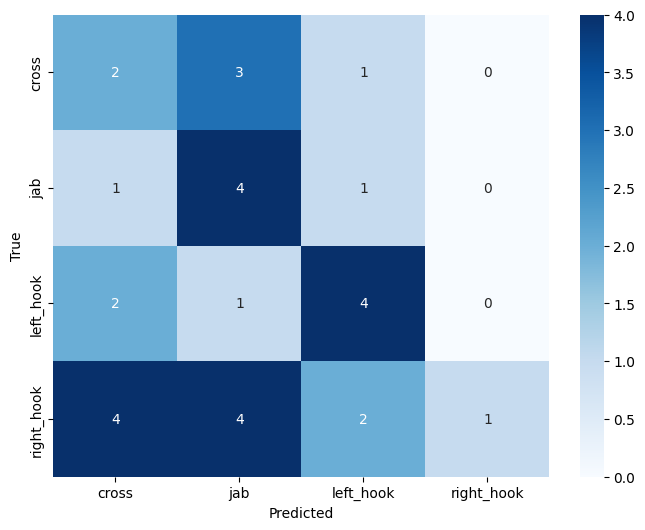

In [235]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

X_test = np.array(X_test)
n_samples = X_test.shape[0]
X_test = X_test.reshape(n_samples, -1)

y_test = np.array(y_test)

# Make predictions on the test data
y_pred = SVM.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
svm_report = classification_report(y_test, y_pred)

# Display the evaluation metrics
print("Accuracy:", accuracy)
print("SVM Classification Report:")
print(svm_report)

cm = confusion_matrix(y_test, y_pred)
# Get the class labels from LabelEncoder
class_labels = label_encoder.classes_

# Display the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Naive Bayes

Accuracy: 0.4
Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.14      0.17      0.15         6
           1       0.50      0.50      0.50         6
           2       0.44      0.57      0.50         7
           3       0.50      0.36      0.42        11

    accuracy                           0.40        30
   macro avg       0.40      0.40      0.39        30
weighted avg       0.42      0.40      0.40        30



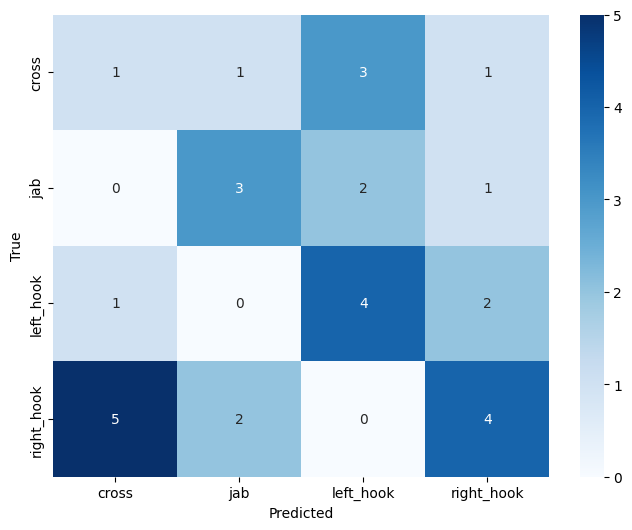

In [236]:
from sklearn.naive_bayes import GaussianNB

NB = GaussianNB()

NB.fit(X_train, y_train)
y_pred_nb = NB.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_nb)
svm_report = classification_report(y_test, y_pred_nb)

# Display the evaluation metrics
print("Accuracy:", accuracy)
print("Naive Bayes Classification Report:")
print(svm_report)

cm = confusion_matrix(y_test, y_pred_nb)
# Get the class labels from LabelEncoder
class_labels = label_encoder.classes_

# Display the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


### Cross validation

Accuracy: 0.46938775510204084
Naive-Bayes Cross-Validation Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.40      0.43        25
           1       0.54      0.61      0.57        23
           2       0.38      0.40      0.39        25
           3       0.50      0.48      0.49        25

    accuracy                           0.47        98
   macro avg       0.47      0.47      0.47        98
weighted avg       0.47      0.47      0.47        98



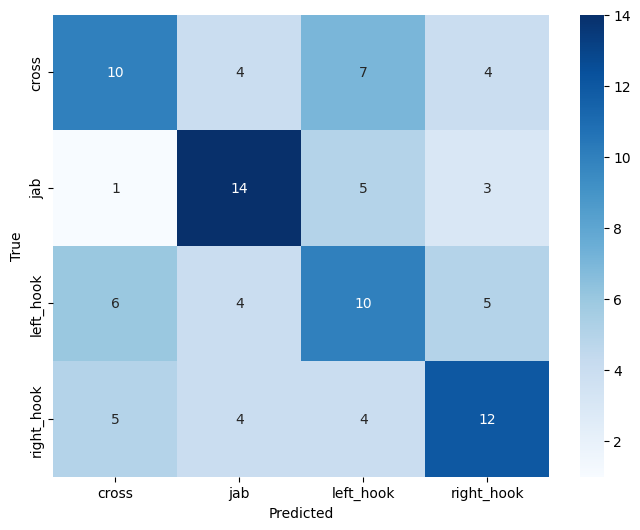

In [237]:
from sklearn.model_selection import cross_val_score, cross_val_predict

NB1 = GaussianNB()
X = np.array(flattened_descriptors)
y = np.array(encoded_labels)
scores = cross_val_score(NB1, X, y, cv=10)

# print(f'Accuracy {scores.mean()} (+/- {scores.std() * 2})')

y_pred_nb_cv = cross_val_predict(NB1, X, y, cv=10)

# Calculate evaluation metrics
accuracy = accuracy_score(y, y_pred_nb_cv)
svm_report = classification_report(y, y_pred_nb_cv)

# Display the evaluation metrics
print("Accuracy:", accuracy)
print("Naive-Bayes Cross-Validation Classification Report:")
print(svm_report)

cm = confusion_matrix(y, y_pred_nb_cv)
# Get the class labels from LabelEncoder
class_labels = label_encoder.classes_

# Display the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


### Multi-layer Perceptron

In [ ]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()